In [1]:
import sys
import os
import gc
import numpy as np
from SSIM import ssim
#import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
from ADMM import PnPADMM
import neural_network_models as nnm
import time
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from undersampling2 import usam_data

In [2]:
data_path = '/home/deepak/CS_MRI_codes_simulation/MRI_MCCAI_data/training_gt_split_2'
model_save_path = '/home/deepak/CS_MRI_codes_simulation/MRI_MCCAI_data/'

In [3]:
def constructDenoiser(model_save_path):
    # infogan-based denoiser
    g_model = nnm.Generator()
    proj_model = nnm.Projector()
    denoiser_InfoGAN = nnm.GenBasedDenoiser(model_save_path, g_model,proj_model)
    print ("infogan-based denoiser constructed")
    return denoiser_InfoGAN


In [81]:
def setAlgoParams(M):
    algo_param = {"rho": 1/16,
                  "x0": np.random.randn(256,256),
                  "tol": 50,
                  "maxiter": 10,
                  "callback": None}
            
    return algo_param


In [49]:
#functions for loading the data as a randomized batch
def load_data(file_name):
    with open(file_name,'rb') as f:
        data = pickle.load(f)
    f.close()
    gc.collect()
    return data

def batch_wise_split(n_files, batch_size):
    X = np.arange(n_files)
    random_file_choice = np.random.choice(X, 1)
    file_name = 'train_gt_%04d.pickle'% (random_file_choice+1)
    data_loaded = load_data(os.path.join(data_path, file_name))
    slice_sel_array = np.arange(len(data_loaded))
    slice_sel = np.random.choice(slice_sel_array, batch_size, replace = False)
    X_train = []
    for i in slice_sel:
        X_train.append(data_loaded[i])
    return X_train

In [50]:
def getTestImages(n_files, n_samples): 
    X = np.array(batch_wise_split(n_files, n_samples))
    return X

In [72]:
def generate_mask(N,M):
    I = np.eye(N)
    r_sel_array = np.arange(N)
    r_sel = np.random.choice(r_sel_array,M,replace = False)
    U_mask = np.zeros_like(I)
    U_mat = np.zeros_like(I)
    for i in r_sel:
        U_mask[i,:] = np.ones((1,N))
        U_mat[i,:] = I[i,:]
    return U_mask, U_mat

In [ ]:
# with open(os.path.join(model_save_path,'mask_1dg_a3pt33.pickle'),'rb') as f:
#     mask = pickle.load(f)


In [ ]:
# M = 128*128
# N = 256*256
# A_prob = np.random.rand(M, N)
# p = .1
# A = np.zeros((M, N))
# A[A_prob < p/2.] = 0 
# A[A_prob > 1-p/2.] = 1 

# mask = A

In [229]:
# Program parameters
show_plot = True
n_test = 10
M = 192
N = 256
n_files = 100
# comp_ratios = [4] 

# Get test set
test_imgs = getTestImages(n_files, n_test)

mask, mask_mat = generate_mask(N,M)
# Construct denoisers
denoiser = constructDenoiser(model_save_path)


infogan-based denoiser constructed


In [230]:
t = 4

test_image 1 -----------
10
4
torch.Size([1, 1, 256, 256])
pixel dom L2 error:  51.35312325453124
ssim 0.6180659532546997
test_image 2 -----------
10
3
torch.Size([1, 1, 256, 256])
pixel dom L2 error:  47.00327494307494
ssim 0.622073769569397
test_image 3 -----------
10
5
torch.Size([1, 1, 256, 256])
pixel dom L2 error:  61.82535171721082
ssim 0.5554347038269043
test_image 4 -----------
10
2
torch.Size([1, 1, 256, 256])
pixel dom L2 error:  52.75693580349483
ssim 0.5812121629714966
test_image 5 -----------
10
0
torch.Size([1, 1, 256, 256])
pixel dom L2 error:  59.1871131933858
ssim 0.6882784366607666
test_image 6 -----------
10
1
torch.Size([1, 1, 256, 256])
pixel dom L2 error:  53.59329882838426
ssim 0.5778419971466064
test_image 7 -----------
10
1
torch.Size([1, 1, 256, 256])
pixel dom L2 error:  47.37092693007055
ssim 0.7019022703170776
test_image 8 -----------
10
0
torch.Size([1, 1, 256, 256])
pixel dom L2 error:  48.12022817352544
ssim 0.7860845327377319
test_image 9 -----------
1

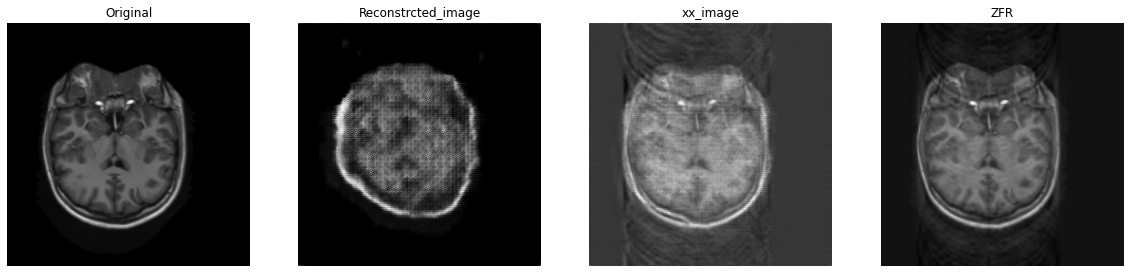

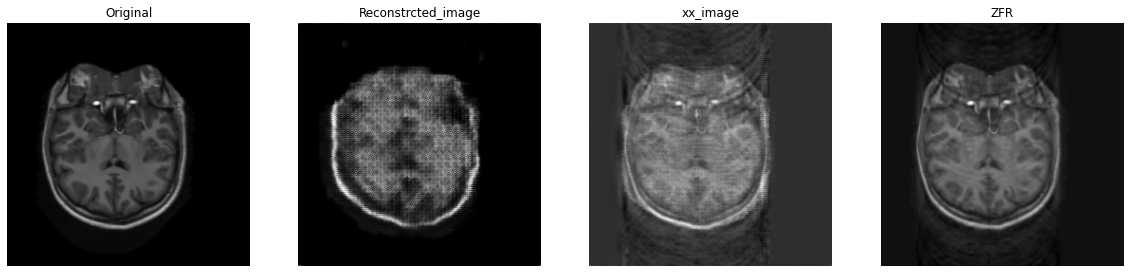

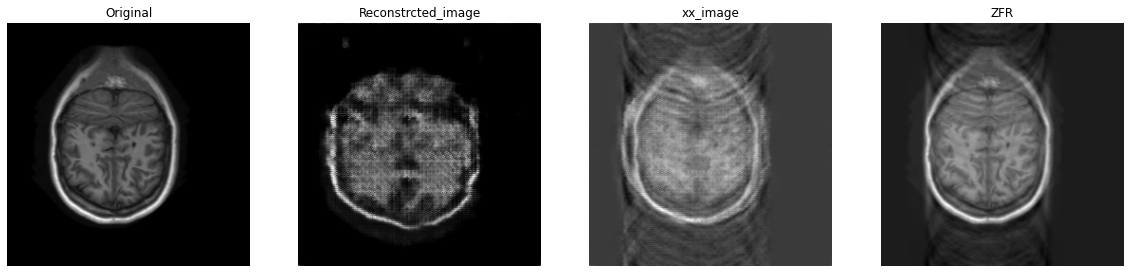

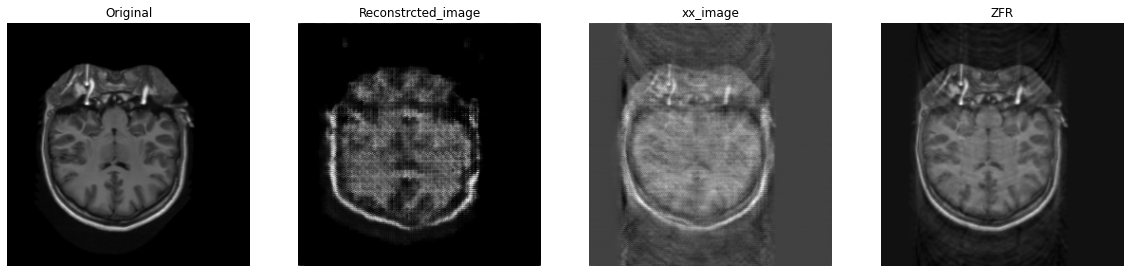

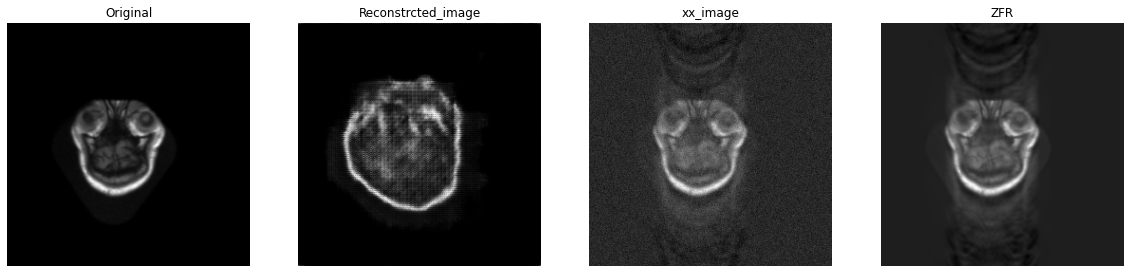

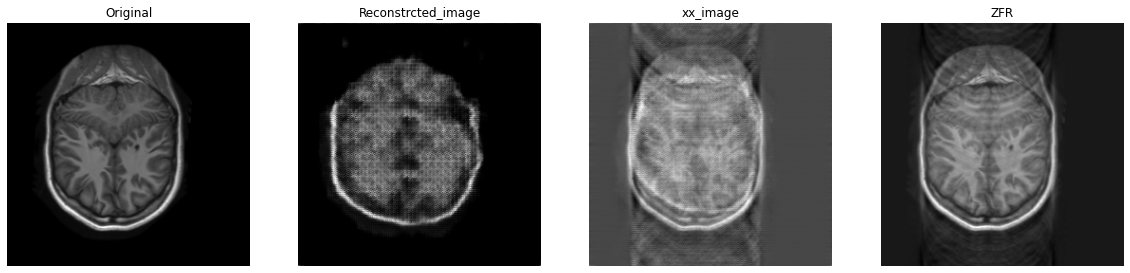

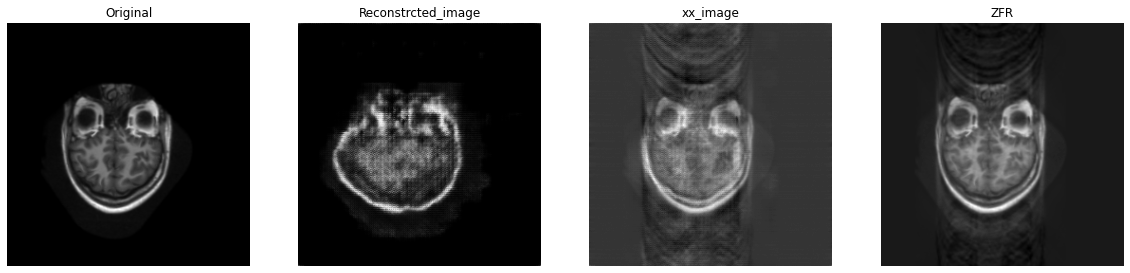

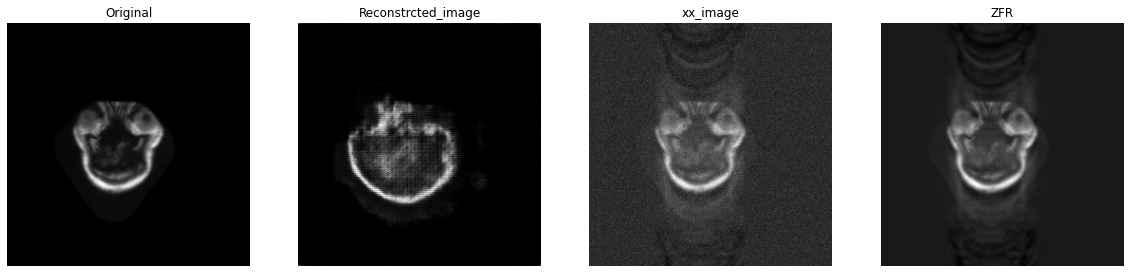

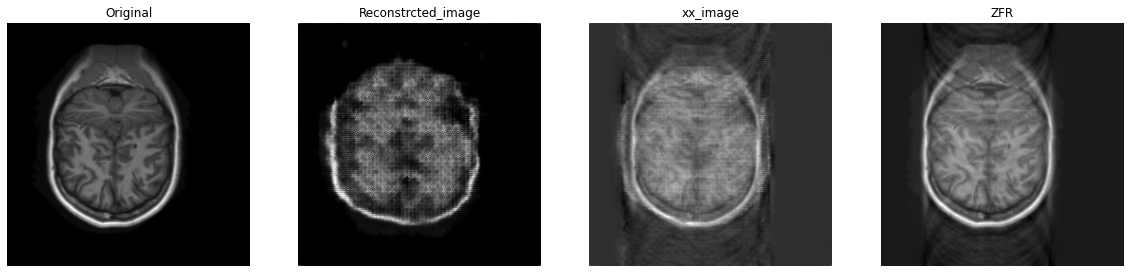

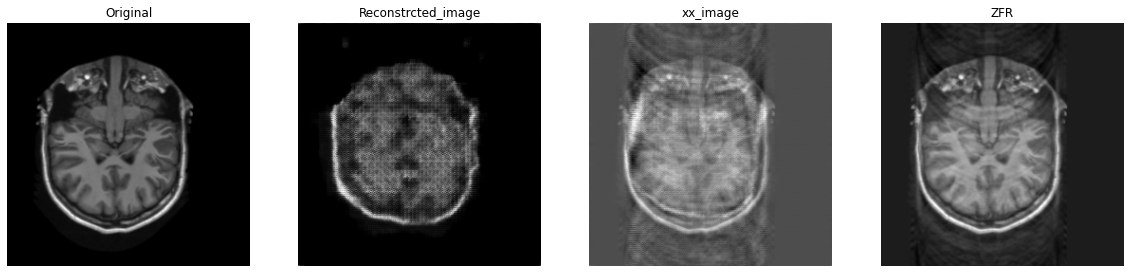

Time Taken:0.53m


In [231]:

# dictionary storing all the recovered results
results_x = []
results_lb = []
results_xr = []
ssim_list = []
pix_mse_list = []

start_time = time.time()
for i in range(n_test):
    print ("test_image", i+1, "-----------")

    # true image
    x_true = test_imgs[i]
    results_x.append(x_true)

    # CS setups
    y = usam_data(x_true, mask) #the zero filled reconstruction after undersampling in kspace.


    # Construct a PnPADMM solver
    algo_params_dict = setAlgoParams(M)

    # Solve
    solver = PnPADMM(M, N, algo_params_dict)
    x_star, xx_star, loss_rec = solver.solve(y, mask, mask_mat, denoiser)


    results_xr.append(x_star)
    
    img1 = x_true
    img2 = x_star
    ssim_score = ssim(img1, img2, 2, 1.5, window_size=11, size_average=True)
    ssim_list.append(ssim_score)
    pix_mse = np.linalg.norm(x_star-x_true)
    pix_mse_list.append(pix_mse)
    print ("pixel dom L2 error: ", pix_mse)
    print("ssim",ssim_score.item())
    
#     k = range(len(loss_rec))
#     l = loss_rec
#     plt.plot(k,l)
#     plt.show()

    # Show results
    if show_plot and n_test <= 10:
        plt.figure(figsize=(20,5))
        plt.subplot(1,4,1)
        plt.imshow((x_true), origin="upper", cmap="gray")
        plt.axis('off')
        plt.title("Original")
        plt.subplot(1,4,2)
        plt.imshow((x_star), origin="upper", cmap="gray")
        plt.title("Reconstrcted_image")
        plt.axis('off')
        plt.subplot(1,4,3)
        plt.imshow((xx_star), origin="upper", cmap="gray")
        plt.title("xx_image")
        plt.axis('off')
        plt.subplot(1,4,4)
        plt.imshow(np.real(np.fft.ifft2(y)),origin = "upper", cmap= 'gray')
        plt.title("ZFR")
        plt.axis('off')
        fig_name = "recon_res_cr_1_33_gen_imgs_proj_t_%02d_i_%02d"% (t+1,i+1)
        plt.savefig(os.path.join(model_save_path,fig_name))
plt.show()
end_time = time.time()-start_time
print('Time Taken:%.2fm' %(end_time/60))

In [232]:
n_imgs = range(n_test)
s = ssim_list
mse = pix_mse_list 

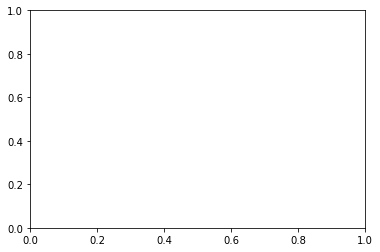

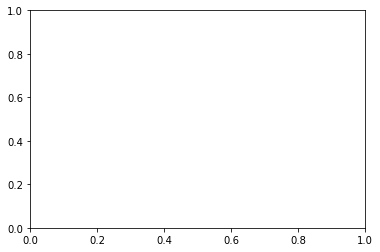

In [198]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

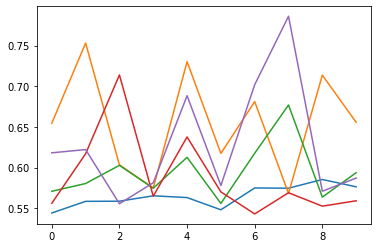

In [233]:
ax1.plot(n_imgs,s)
fig1

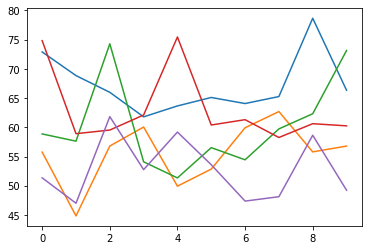

In [234]:
ax2.plot(n_imgs,mse)
fig2